# Training of a conditional diffusion model

In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())  
print(torch.cuda.device_count()) 
print(torch.cuda.current_device()) 

2.1.0
0.16.0
True
1
0


## Importing modules

In [3]:
import numpy as np
import os
import random
import glob
import argparse, logging, copy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from tqdm import tqdm
from IPython.display import clear_output
from pathlib import Path
from PIL import Image
from types import SimpleNamespace
from contextlib import nullcontext
from fastprogress import progress_bar
from modules import UNet_conditional, EMA
from datetime import datetime

import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
batch_size = 15 

## train_dataset/train_dataloader

In [5]:
# Load conditions from the output file

points = 64       

tra_out_dir = "./train_val_test/train_out/"
files = os.listdir(tra_out_dir)
results_tra = [] 
folders = []
labels_list = []
labels_tra = []

# Retrieve filenames from the x directory at 160°C and create a list 
# (Use the same list for other temperatures and y, xy)
xdir = "./train_val_test/train_out/train_out_160/x/"
files = os.listdir(xdir)
files_list_tra = [os.path.splitext(f)[0] for f in files if os.path.isfile(os.path.join(xdir, f))]


for folder_name in os.listdir(tra_out_dir):
    if folder_name[0:9]=='train_out': 
        folders.append(folder_name)
folders.sort()

for index in tqdm(range(len(folders))): 
    folder_name = folders[index]
    folder_path = os.path.join(tra_out_dir, folder_name)
    
    for n in range(len(files_list_tra)): 
        if folder_name[0:13]=='train_out_160':
            path_x = "./train_val_test/train_out/train_out_160/x/"+ str(files_list_tra[n])+".out"
            path_y = "./train_val_test/train_out/train_out_160/y/"+ str(files_list_tra[n])+".out"
            path_xy = "./train_val_test/train_out/train_out_160/xy/"+ str(files_list_tra[n])+".out"
        elif folder_name[0:13]=='train_out_180':
            path_x = "./train_val_test/train_out/train_out_180/x/"+ str(files_list_tra[n])+".out"
            path_y = "./train_val_test/train_out/train_out_180/y/"+ str(files_list_tra[n])+".out"
            path_xy = "./train_val_test/train_out/train_out_180/xy/"+ str(files_list_tra[n])+".out"
        elif folder_name[0:13]=='train_out_200':
            path_x = "./train_val_test/train_out/train_out_200/x/"+ str(files_list_tra[n])+".out"
            path_y = "./train_val_test/train_out/train_out_200/y/"+ str(files_list_tra[n])+".out"
            path_xy = "./train_val_test/train_out/train_out_200/xy/"+ str(files_list_tra[n])+".out"  
        elif folder_name[0:13]=='train_out_220':
            path_x = "./train_val_test/train_out/train_out_220/x/"+ str(files_list_tra[n])+".out"
            path_y = "./train_val_test/train_out/train_out_220/y/"+ str(files_list_tra[n])+".out"
            path_xy = "./train_val_test/train_out/train_out_220/xy/"+ str(files_list_tra[n])+".out" 

        # Specify the value to be taken from the out file
        with open(path_x, 'r') as file_x, open(path_y, 'r') as file_y, open(path_xy, 'r') as file_xy:
            x = float(file_x.readlines()[-1].strip().split()[4]) 
            y = float(file_y.readlines()[-1].strip().split()[5]) 
            xy = float(file_xy.readlines()[-1].strip().split()[7])
        results_tra.append(np.array([x, y, xy])) 

# Normalize
results_tra_num = np.array(results_tra)
min_value = np.amin(results_tra_num) 
max_value = np.amax(results_tra_num)

def normalize(value, min_val, max_val): 
    return (value - min_val) / (max_val - min_val)

for loop in range(len(results_tra)):
    labels_tra.append(normalize(results_tra[loop],min_value,max_value))

labels_list_tra1 = [item for pair in zip(labels_tra, labels_tra) for item in pair]
labels_list_tra2 = [item for pair in zip(labels_tra, labels_tra) for item in pair]
labels_list= [item for pair in zip(labels_list_tra1, labels_list_tra2) for item in pair]

y =  labels_list 
print(len(labels_list))
print(type(labels_list))
print(labels_list[0])

100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

72
<class 'list'>
[0.36017368 0.15198248 0.04436603]


In [6]:
# Load vtk file

def get_dataset_tra(v_range=1):
    result_dir = "./train_val_test/train_vtk/"
    folders = []
    
    for folder_name in os.listdir(result_dir):
        if folder_name[0:9]=='train_vtk': 
            folders.append(folder_name)
            
    folders.sort()
    
    # Where the phase-field variables are defined
    phi_start=4106-1 # See dat file 
    phi_end=8201     # See dat file

    v_range=1 # Range of value: 1 or 255 should be put
    
    images_list = []
    for index in tqdm(range(len(folders))): 
        folder_name = folders[index]
        folder_path = os.path.join(result_dir, folder_name)

        for n in range(len(files_list_tra)): 
            if folder_name[0:13]=='train_vtk_160':
                vtk_path = "./train_val_test/train_vtk/train_vtk_160/"+ str(files_list_tra[n])+".vtk" 
            elif folder_name[0:13]=='train_vtk_180':
                vtk_path = "./train_val_test/train_vtk/train_vtk_180/"+ str(files_list_tra[n])+".vtk"
            elif folder_name[0:13]=='train_vtk_200':
                vtk_path = "./train_val_test/train_vtk/train_vtk_200/"+ str(files_list_tra[n])+".vtk" 
            elif folder_name[0:13]=='train_vtk_220':
                vtk_path = "./train_val_test/train_vtk/train_vtk_220/"+ str(files_list_tra[n])+".vtk"
        
            with open(vtk_path) as f:
                l = [s.strip() for s in f.readlines()]
                temp  = l[phi_start:phi_end]
                temp = [float(s) for s in temp]
                img1 = np.zeros((points,points))                
            for i in range(points):
                for j in range(points):
                    img1[i,j] = float(temp[i*points+j])
                    img1[i,j] = np.where(img1[i,j] < 0.5, -1, 1) # binarization

            # Creating images representing process parameters
            img_sin = Image.new("L", (64, 64)) 
            Amp    = 255.0        
            T      = 32.0
            # Specify the frequency for each temperature
            if folder_name[0:13]=='train_vtk_160': 
                f = 1.0 / 10.0 
            elif folder_name[0:13]=='train_vtk_180':
                f = 1.0 / 20.0 
            elif folder_name[0:13]=='train_vtk_200':
                f = 1.0 / 30.0 
            elif folder_name[0:13]=='train_vtk_220':
                f = 1.0 / 40.0  
            sec = 1         
            f_s = 1000      
            offset = 255    

            Brightness=[]
            for t in np.arange(f_s * sec):
                y = Amp * np.sin(2.0 * np.pi * f * t) + offset
                y = y / 2
                Brightness.append(y)

            for x in range(points):
                for y in range(points):
                    r = int(round(Brightness[x]))
                    img_sin.putpixel((x,y),(r))

            numpy_img_sin = np.array(img_sin) 
            img2 = (numpy_img_sin/255)*2-1 
        
            imgs = []
            imgs.append(img1) 
            imgs.append(img2) 
            images_list.append(imgs) 
            
    images_list = np.array(images_list).transpose(0,2,3,1)     
    
    return images_list

In [7]:
# Only crystal microstructure images are rotated or flipped. 
# Process parameter images are not rotated or flipped.

def data_augmentation(images_list):
    aug_images_list = []
    for i in tqdm(range(images_list.shape[0])):
        img = images_list[i]
        img_1 = img[:,:,0]
        img_2 = img[:,:,1]
        img = np.stack([img_1, img_2], axis=-1)
        img180_1 = np.rot90(img_1,2)
        img180 = np.stack([img180_1, img_2], axis=-1)
        r_img_1 = np.fliplr(img_1)
        r_img = np.stack([r_img_1, img_2], axis=-1)
        r_img180_1 = np.rot90(r_img_1,2)
        r_img180 = np.stack([r_img180_1, img_2], axis=-1)
        img_stack = list([img, img180, r_img, r_img180]) 
        aug_images_list += img_stack
    aug_images_list = np.array(aug_images_list)
    print("size of total dataset images_list:",aug_images_list.shape)
    return aug_images_list

In [8]:
# Transform
class MyTransform():
    def __init__(self, isNormalize=True):
        if isNormalize:
            self.my_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, )) 
            ])
        else:
            self.my_transform = transforms.Compose([
                transforms.ToTensor()
            ])
    def __call__(self, img):
        return self.my_transform(img)

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, labels_list=None, transform=None, v_range=1, mode="train", save_dir=None):
        self.transform = transform
        self.v_range = v_range

        if save_dir is not None:
            data_file = os.path.join(save_dir, f"{mode}_dataset_data.npy")
            label_file = os.path.join(save_dir, f"{mode}_dataset_label.npy")

            print(f"Creating {mode} dataset and saving to {save_dir}")
            self.data = data_augmentation(get_dataset_tra())
            self.label = labels_list
            np.save(data_file, self.data)
            np.save(label_file, self.label)
            
        else:
            self.data = data_augmentation(get_dataset_tra())
            self.label = labels_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label

In [10]:
save_dir = "saved_datasets/train"

data_tra = MyDataset(labels_list, transform=MyTransform(isNormalize=False), mode="train", save_dir=save_dir)
print('train_dataset', len(data_tra))

os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, "train_dataset_data.npy"), data_tra.data)
np.save(os.path.join(save_dir, "train_dataset_label.npy"), data_tra.label)

dataloader_settings = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": 4,
    "drop_last": True
}

np.save(os.path.join(save_dir, "dataloader_settings.npy"), dataloader_settings)

g = torch.Generator()
g.manual_seed(42)

train_dataloader = torch.utils.data.DataLoader(data_tra, **dataloader_settings, generator=g)
print('train_dataloader', len(train_dataloader))

Creating train dataset and saving to saved_datasets/train


100%|██████████| 18/18 [00:00<00:00, 912.22it/s]

size of total dataset images_list: (72, 64, 64, 2)
train_dataset 72
train_dataloader 4


In [11]:
print(data_tra.data.shape)

(72, 64, 64, 2)


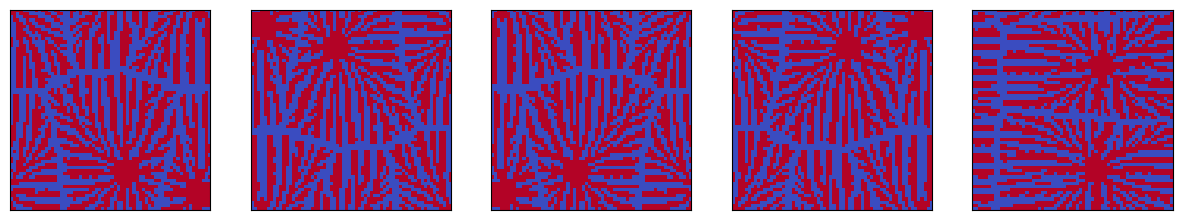

In [12]:
# When seeing the dataset --> Since it hasn't been shuffled, it's in order

plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_tra[i]
    img = img[0] 
    plt.subplot(1,5,i+1) 
    plt.imshow(img, cmap="coolwarm",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

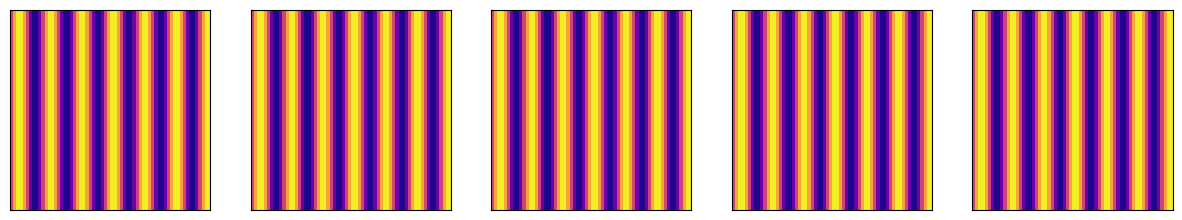

In [13]:
plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_tra[i]
    img2 = img[1]
    plt.subplot(1,5,i+1)
    plt.imshow(img2, cmap="plasma",norm=Normalize(vmin=-1,vmax=1))
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

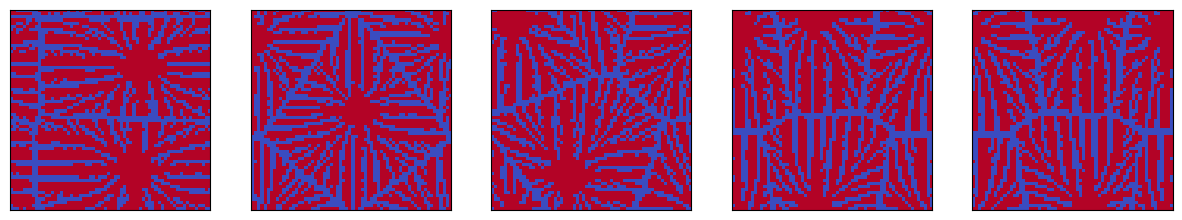

In [14]:
# When seeing the dataloader --> Since it has been shuffled, it is not in order
plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(1,5,i+1)
    batch = next(iter(train_dataloader))
    img = batch[0][i][0]
    plt.imshow(img, cmap="coolwarm",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)  

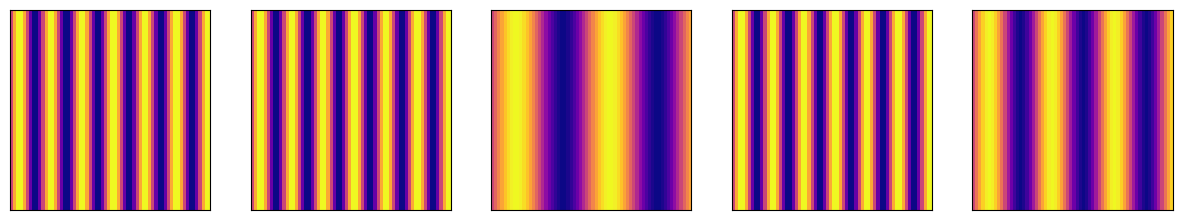

In [15]:
plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(1,5,i+1)
    batch = next(iter(train_dataloader))
    img = batch[0][i][1]
    plt.imshow(img, cmap="plasma",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False) 

## validation_dataset/validation_dataloader

In [16]:
points = 64     

val_out_dir = "./train_val_test/val_out/"
files = os.listdir(val_out_dir)
results_val = []
folders = []
labels_list = []
labels_val = []

valxdir = "./train_val_test/val_out/val_out_160/x/"
files = os.listdir(valxdir)
files_list_val = [os.path.splitext(f)[0] for f in files if os.path.isfile(os.path.join(valxdir, f))]


for folder_name in os.listdir(val_out_dir):
    if folder_name[0:7]=='val_out':
        folders.append(folder_name)
folders.sort()

for index in tqdm(range(len(folders))): 
    folder_name = folders[index]
    folder_path = os.path.join(val_out_dir, folder_name)
    
    for n in range(len(files_list_val)): 
        if folder_name[0:11]=='val_out_160':
            path_x = "./train_val_test/val_out/val_out_160/x/"+ str(files_list_val[n])+".out"
            path_y = "./train_val_test/val_out/val_out_160/y/"+ str(files_list_val[n])+".out"
            path_xy = "./train_val_test/val_out/val_out_160/xy/"+ str(files_list_val[n])+".out"
        elif folder_name[0:11]=='val_out_180':
            path_x = "./train_val_test/val_out/val_out_180/x/"+ str(files_list_val[n])+".out"
            path_y = "./train_val_test/val_out/val_out_180/y/"+ str(files_list_val[n])+".out"
            path_xy = "./train_val_test/val_out/val_out_180/xy/"+ str(files_list_val[n])+".out"
        elif folder_name[0:11]=='val_out_200':
            path_x = "./train_val_test/val_out/val_out_200/x/"+ str(files_list_val[n])+".out"
            path_y = "./train_val_test/val_out/val_out_200/y/"+ str(files_list_val[n])+".out"
            path_xy = "./train_val_test/val_out/val_out_200/xy/"+ str(files_list_val[n])+".out"  
        elif folder_name[0:11]=='val_out_220':
            path_x = "./train_val_test/val_out/val_out_220/x/"+ str(files_list_val[n])+".out"
            path_y = "./train_val_test/val_out/val_out_220/y/"+ str(files_list_val[n])+".out"
            path_xy = "./train_val_test/val_out/val_out_220/xy/"+ str(files_list_val[n])+".out" 


        with open(path_x, 'r') as file_x, open(path_y, 'r') as file_y, open(path_xy, 'r') as file_xy:
            x = float(file_x.readlines()[-1].strip().split()[4])
            y = float(file_y.readlines()[-1].strip().split()[5])
            xy = float(file_xy.readlines()[-1].strip().split()[7])
        results_val.append(np.array([x, y, xy]))        

results_val_num = np.array(results_val)
min_value = np.amin(results_val_num)
max_value = np.amax(results_val_num)

def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)
for loop in range(len(results_val)):
    labels_val.append(normalize(results_val[loop],min_value,max_value))

labels_list_val1 = [item for pair in zip(labels_val, labels_val) for item in pair]
labels_list_val2 = [item for pair in zip(labels_val, labels_val) for item in pair]
labels_list= [item for pair in zip(labels_list_val1, labels_list_val2) for item in pair]

y =  labels_list
print(len(labels_list))
print(type(labels_list))
print(labels_list[0])

100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

24
<class 'list'>
[0.30833359 0.14662979 0.        ]


In [17]:
def get_dataset_val(v_range=1):
    result_dir = "./train_val_test/val_vtk/"
    folders = []
    
    for folder_name in os.listdir(result_dir):
        if folder_name[0:7]=='val_vtk': 
            folders.append(folder_name)
            
    folders.sort()
    
    phi_start=4106-1 
    phi_end=8201 

    v_range=1      
    
    images_list = []
    for index in tqdm(range(len(folders))):
        folder_name = folders[index]
        folder_path = os.path.join(result_dir, folder_name)

        for n in range(len(files_list_val)): 
            if folder_name[0:11]=='val_vtk_160':
                vtk_path = "./train_val_test/val_vtk/val_vtk_160/"+ str(files_list_val[n])+".vtk"
            elif folder_name[0:11]=='val_vtk_180':
                vtk_path = "./train_val_test/val_vtk/val_vtk_180/"+ str(files_list_val[n])+".vtk"
            elif folder_name[0:11]=='val_vtk_200':
                vtk_path = "./train_val_test/val_vtk/val_vtk_200/"+ str(files_list_val[n])+".vtk" 
            elif folder_name[0:11]=='val_vtk_220':
                vtk_path = "./train_val_test/val_vtk/val_vtk_220/"+ str(files_list_val[n])+".vtk"
            
            with open(vtk_path) as f:
                l = [s.strip() for s in f.readlines()]
                temp  = l[phi_start:phi_end]
                temp = [float(s) for s in temp]
                img1 = np.zeros((points,points))                

            for i in range(points):
                for j in range(points):
                    img1[i,j] = float(temp[i*points+j])
                    img1[i,j] = np.where(img1[i,j] < 0.5, -1, 1)
                    
            img_sin = Image.new("L", (64, 64)) 

            Amp    = 255.0        
            T      = 32.0       
            f = 1.0 / 30.0
            if folder_name[0:11]=='val_vtk_160':
                f = 1.0 / 10.0
            elif folder_name[0:11]=='val_vtk_180':
                f = 1.0 / 20.0
            elif folder_name[0:11]=='val_vtk_200':
                f = 1.0 / 30.0 
            elif folder_name[0:11]=='val_vtk_220':
                f = 1.0 / 40.0 
            sec = 1          
            f_s = 1000       
            offset = 255     
 
            Brightness=[]
            for t in np.arange(f_s * sec):
                y = Amp * np.sin(2.0 * np.pi * f * t) + offset
                y = y / 2
                Brightness.append(y)

            for x in range(points):
                for y in range(points):
                    r = int(round(Brightness[x]))

                    img_sin.putpixel((x,y),(r))

            numpy_img_sin = np.array(img_sin) 
            img2 = (numpy_img_sin/255)*2-1 
        
            imgs = []
            imgs.append(img1)
            imgs.append(img2)
            images_list.append(imgs)
            
    images_list = np.array(images_list).transpose(0,2,3,1)    
    
    return images_list

In [18]:
def data_augmentation(images_list):
    aug_images_list = []
    
    for i in tqdm(range(images_list.shape[0])):
        img = images_list[i]
        img_1 = img[:,:,0]
        img_2 = img[:,:,1]
        img = np.stack([img_1, img_2], axis=-1)
        img180_1 = np.rot90(img_1,2)
        img180 = np.stack([img180_1, img_2], axis=-1)
        r_img_1 = np.fliplr(img_1)
        r_img = np.stack([r_img_1, img_2], axis=-1)
        r_img180_1 = np.rot90(r_img_1,2)
        r_img180 = np.stack([r_img180_1, img_2], axis=-1)
        img_stack = list([img, img180, r_img, r_img180])
        aug_images_list += img_stack
    aug_images_list = np.array(aug_images_list)
    print("size of total dataset images_list:",aug_images_list.shape)
    return aug_images_list

In [19]:
class MyTransform():
    def __init__(self, isNormalize=True):
        if isNormalize:
            self.my_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, )) 
            ])
        else:
            self.my_transform = transforms.Compose([
                transforms.ToTensor()
            ])
    def __call__(self, img):
        return self.my_transform(img)

In [20]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, labels_list=None, transform=None, v_range=1, mode="val", save_dir=None):
        self.transform = transform
        self.v_range = v_range

        if save_dir is not None:
            data_file = os.path.join(save_dir, f"{mode}_dataset_data.npy")
            label_file = os.path.join(save_dir, f"{mode}_dataset_label.npy")

            if os.path.exists(data_file) and os.path.exists(label_file):
                print(f"Loading {mode} dataset from {save_dir}")
                self.data = np.load(data_file)
                self.label = np.load(label_file, allow_pickle=True)
            else:
                print(f"Creating {mode} dataset and saving to {save_dir}")
                self.data = data_augmentation(get_dataset_val())
                self.label = labels_list
                np.save(data_file, self.data)
                np.save(label_file, self.label)
        else:
            self.data = data_augmentation(get_dataset_val())
            self.label = labels_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label

In [21]:
save_dir = "saved_datasets/val"

data_val = MyDataset(labels_list, transform=MyTransform(isNormalize=False), mode="val", save_dir=save_dir)
print('val_dataset', len(data_val))

os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, "val_dataset_data.npy"), data_val.data)
np.save(os.path.join(save_dir, "val_dataset_label.npy"), data_val.label)

dataloader_settings = {
    "batch_size": batch_size,
    "shuffle": False,   
    "num_workers": 4,
    "drop_last": False
}

np.save(os.path.join(save_dir, "dataloader_settings.npy"), dataloader_settings)

val_dataloader = torch.utils.data.DataLoader(data_val, **dataloader_settings)
print('val_dataloader', len(val_dataloader))

Loading val dataset from saved_datasets/val
val_dataset 24
val_dataloader 2


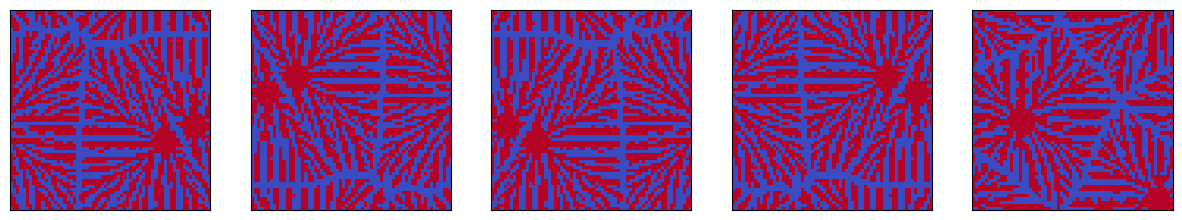

In [22]:
# When seeing the dataset 

plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_val[i]
    img = img[0]
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap="coolwarm",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

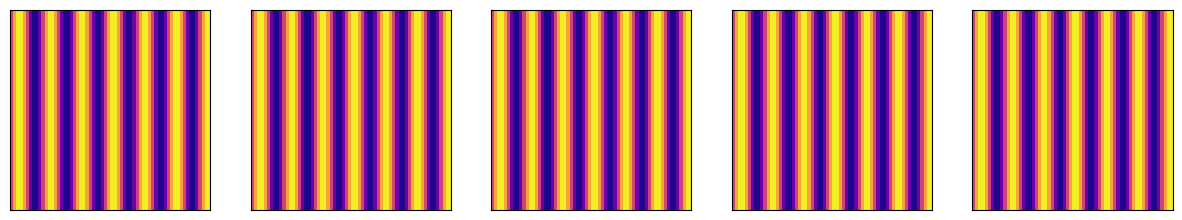

In [23]:
plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_val[i]
    img2 = img[1]
    plt.subplot(1,5,i+1)
    plt.imshow(img2, cmap="plasma",norm=Normalize(vmin=-1,vmax=1))
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

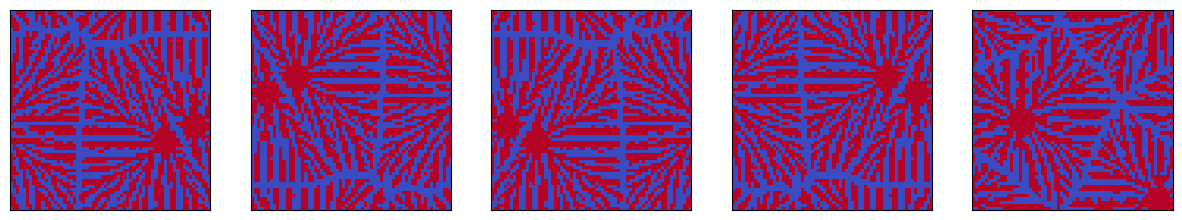

In [24]:
# When seeing the dataloader

plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(1,5,i+1)
    batch = next(iter(val_dataloader))
    img = batch[0][i][0]
    plt.imshow(img, cmap="coolwarm",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False) 

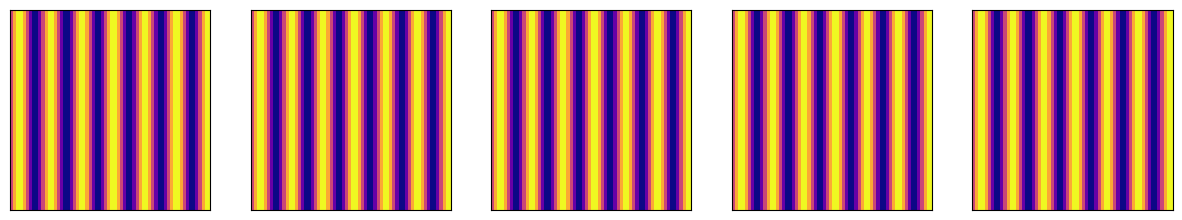

In [25]:
plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(1,5,i+1)
    batch = next(iter(val_dataloader))
    img = batch[0][i][1]
    plt.imshow(img, cmap="plasma",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)  

In [26]:
gpu = torch.device("cuda")
cpu = torch.device("cpu")
print(gpu)

cuda


## ddpm_conditional

In [27]:
lr_ddpm = 1e-4
epochs_ddpm = 10000 
config = SimpleNamespace(    
    run_name = "DDPM_conditional",
    epochs = epochs_ddpm,
    noise_steps=1000,
    seed = 42,
    batch_size = batch_size, 
    img_size = 64,
    device = "cuda",
    slice_size = 1,
    do_validation = True,
    fp16 = True,
    log_every_epoch = 1000,
    num_workers=4,
    lr = lr_ddpm)

In [28]:
config 

namespace(run_name='DDPM_conditional',
          epochs=10000,
          noise_steps=1000,
          seed=42,
          batch_size=15,
          img_size=64,
          device='cuda',
          slice_size=1,
          do_validation=True,
          fp16=True,
          log_every_epoch=1000,
          num_workers=4,
          lr=0.0001)

In [29]:
def set_seed(s, reproducible=False):
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [30]:
now = datetime.now().strftime("%H%M%S")
model_save_dir = os.path.join("./models", "models_{0}_{1}".format(now, lr_ddpm))
os.makedirs(model_save_dir, exist_ok=True)  

In [31]:
save_epoch = 10

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, c_in=2, c_out=2,  device="cuda", **kwargs): 
        self.noise_steps = noise_steps 
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.now = now
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.model = UNet_conditional(c_in, c_out, **kwargs).to(device)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.device = device
        self.c_in = c_in
    
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
    
    @torch.inference_mode()
    def sample(self, use_ema, labels, cfg_scale=3): 
        model = self.ema_model if use_ema else self.model
        n = len(labels)
        model.eval()
        with torch.inference_mode():
            x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device) 
            for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        return x

    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()

    def one_epoch(self, train=True):
        avg_loss = 0.
        if train: 
            self.model.train()
            pbar = progress_bar(train_dataloader, leave=False)
        
        else: 
            self.model.eval()
            pbar = progress_bar(val_dataloader, leave=False)
        for i, (images, labels) in enumerate(pbar):
            with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                images = images.to(self.device).float()
                labels = labels.to(self.device)
                t = self.sample_timesteps(images.shape[0]).to(self.device)
                x_t, noise = self.noise_images(images, t)
                if np.random.random() < 0.1:
                    labels = None
                predicted_noise = self.model(x_t, t, labels)
                loss = self.mse(noise, predicted_noise)
                avg_loss += loss
            if train:
                self.train_step(loss)
            pbar.comment = f"MSE={loss.item():2.3f}"   
        return avg_loss.mean()
    
    def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))

        
    def save_model(self, run_name, epoch=-1): 
        torch.save(self.model.state_dict(), os.path.join(model_save_dir, "ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join(model_save_dir, "ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join(model_save_dir, "optim.pt"))

    def prepare(self, args):
        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, eps=1e-5)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr, 
                                                 steps_per_epoch=len(train_dataloader), epochs=args.epochs)
        self.mse = nn.MSELoss()
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()
        
        print(train_dataloader)
        print(val_dataloader)
  
    def fit(self, args):
        loss_li_tra = []
        loss_li_val = []
        date = ""
        
        for epoch in progress_bar(range(args.epochs), total=args.epochs, leave=True):
            avg_loss_tra = self.one_epoch(train=True)
            loss_cpu_tra = avg_loss_tra.detach().to(cpu).numpy().copy()
            # training loss
            if epoch % 1000 == 0: 
                print("tra_loss", avg_loss_tra.item())
            loss_li_tra.append( loss_cpu_tra  )
            if epoch % 1000==0 :
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_tra.append( loss_cpu_tra  )
                plt.plot( loss_li_tra )
                plt.yscale("log")
                plt.title('train_loss,'+"epoch:"+str(epoch))                  
                
            if args.do_validation:
                avg_loss = self.one_epoch(train=False)
                loss_cpu_val = avg_loss.detach().to(cpu).numpy().copy()
            # validation loss
            if epoch % 1000 == 0: 
                print("val_loss", avg_loss.item())
                logging.info(f"Starting epoch {epoch}:")
                loss_li_val.append( loss_cpu_val  )
            if epoch % 1000 == 0 :
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_val.append( loss_cpu_val  )
                plt.plot( loss_li_val )
                plt.yscale("log")
                plt.title('validation_loss,'+"epoch:"+str(epoch))                  

                
            if epoch % save_epoch == save_epoch-1:
                if epoch < save_epoch:
                    self.save_model(run_name=args.run_name, epoch=epoch)
                torch.save(self.model, os.path.join(model_save_dir, "model_{0}.pt".format(epoch)))

            if epoch % save_epoch == save_epoch-1: 
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_tra.append( loss_cpu_tra  )
                plt.plot( loss_li_tra )
                plt.yscale("log")
                plt.title('train_loss,'+"epoch:"+str(epoch))
                plt.savefig(os.path.join(model_save_dir, 'tra_loss{0}.png'.format(epoch)))
                
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_val.append( loss_cpu_val  )
                plt.plot( loss_li_val )
                plt.yscale("log")
                plt.title('validation_loss,'+"epoch:"+str(epoch))  
                plt.savefig(os.path.join(model_save_dir, 'val_loss{0}.png'.format(epoch)))

In [32]:
def parse_args(config):
    import easydict
    args = easydict.EasyDict({
        "run_name": config.run_name,
        "epoch": config.epochs,
        "seed": config.seed,
        "batch_size": config.batch_size,
        "img_size": config.img_size,
        "device": config.device,
        "lr": config.lr,
        "slice_size": config.slice_size,
        "noise_steps": config.noise_steps
    })
    
    for k, v in args.items():
        setattr(config, k, v)

In [ ]:
device="cuda"
if __name__ == '__main__':
    print('True')
    parse_args(config)

    set_seed(config.seed)
    diffuser = Diffusion(config.noise_steps, img_size=config.img_size)
    diffuser.prepare(config)
    diffuser.fit(config)